<a href="https://colab.research.google.com/github/maxrinal/nlp-disaster/blob/master/Rinaldi_91825.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importación del dataset


In [1]:
! python -m textblob.download_corpora
from textblob import TextBlob
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import numpy as np
# from wordcloud import wordcloud, ImageColorGenerator
from wordcloud import WordCloud
import string,re
# Para hacer decode de las url
import urllib.parse
# Para limpiar html entities
import html

test = pd.read_csv('https://raw.githubusercontent.com/maxrinal/nlp-disaster/master/train.csv' ,encoding = 'utf8' )

df_test = test
df_test.sample(n=2)

df_test

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [0]:
# test = pd.read_csv('https://raw.githubusercontent.com/maxrinal/nlp-disaster/master/train.csv' ,encoding = 'utf8' )

# se que luego de wildfire feat hay un html entitie &amp;
# test = pd.read_csv('https://raw.githubusercontent.com/maxrinal/nlp-disaster/master/train.csv' ,encoding = 'utf8' )

# test[test.text.str.lower().str.count('wildfire feat') > 0 ].text


# Limpieza del texto

In [3]:
# Importo el listado de stopwords de english ntlk
# https://www.tutorialspoint.com/python_text_processing/python_remove_stopwords.htm
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Obtengo un "list" de las stop_words más comunes del idioma ingles
english_stop_words = stopwords.words('english')

# Agrego a la lista de remover la palabra vacia
english_stop_words.append('')

print( "Cantidad de palabras " + str(len(english_stop_words)) + "\n" , english_stop_words[10:20] )

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Cantidad de palabras 180
 ["you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']


In [0]:
# Tomo el dataframe original
pd_clean_text = test 

# Transformo todos los textos a minusculas
pd_clean_text.text = pd_clean_text.text.str.lower()

# Remuevo html entities
pd_clean_text.text = pd_clean_text.text.apply( lambda x: html.unescape(  x  ) )

# Hago decode de todos los textos que esten encodeados en formato url
pd_clean_text.text = pd_clean_text.text.apply( lambda x: urllib.parse.unquote( str(x) ) )

# Intento remover todos los links que figuren en el texto
pd_clean_text.text = pd_clean_text.text.apply( lambda x:  re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', str(x) ) )

# Remuevo todos los signos de puntuacion
pd_clean_text.text = pd_clean_text.text.str.translate(str.maketrans('','',string.punctuation))

# Remuevo todos los numeros de la cadena de caracteres
pd_clean_text.text = pd_clean_text.text.str.translate(str.maketrans('','','1234567890'))


# Usando TextBlob transformo los plurales a singulares, como me devuelve una lista tengo que volver a armar el string
pd_clean_text.text = pd_clean_text.text.apply( lambda x: " ".join(TextBlob(x).words.singularize()) )

# stop_words = "at with by that it this from are i was the in a of to and on for is after".split()
# stop_words 

# Separo los textos, borro los stop words y los vuelvo a unir
pd_clean_text.text = pd_clean_text.text.str.split().apply( lambda x: [a for a in x if a not in english_stop_words] ).apply( lambda x: " ".join(x) )


# Cuento uniq words

In [5]:
# Armo un nuevo dataframe con tres columnas, y en cada una de ellsa esta la cantidad de ocurrencias de una palabras
# Se separa en todo el text, solo target_0, solo target_1
pd_str_value_counts = pd.DataFrame({ 
    'full_text' : pd_clean_text.text.str.split(" ", expand=True).unstack().value_counts(),
    't1'  : pd_clean_text[pd_clean_text.target == 1].text.str.split(" ", expand=True).unstack().value_counts(),
    't0'  : pd_clean_text[pd_clean_text.target == 0].text.str.split(" ", expand=True).unstack().value_counts()
})

pd_str_value_counts['t0_belonging_perc']  = 100 * pd_str_value_counts.t0 / pd_str_value_counts.full_text
pd_str_value_counts['t1_belonging_perc']  = 100 * pd_str_value_counts.t1 / pd_str_value_counts.full_text

# Lo ordeno segun la cantidad de ocurrencias totales en el texto
pd_str_value_counts.sort_values(by=['full_text'] , ascending=False ,inplace=True)

#Relleno todos los Nan con zeros
pd_str_value_counts.fillna(0, inplace=True)

# Tomo 10 muestras para visualizar
pd_str_value_counts.sample(n=10)



# all_words = " ".join( pd_clean_text.text.str.split(" ", expand=True).unstack().dropna().tolist() )
# target_0_uniq = pd_clean_text[pd_clean_text.target == 0 ].text.str.split(" ", expand=True).unstack().dropna().unique().tolist()
# target_1_uniq = pd_clean_text[pd_clean_text.target == 1 ].text.str.split(" ", expand=True).unstack().dropna().unique().tolist()


# Cuento cuantas palabras hay de cada uno
# pd_clean_text.text.str.split(" ", expand=True).unstack().dropna().value_counts()



,full_text,t1,t0,t0_belonging_perc,t1_belonging_perc
dtn,4,4.0,0.0,0.0,100.0
xp,4,1.0,3.0,75.0,25.0
set,52,26.0,26.0,50.0,50.0
mood,6,0.0,6.0,100.0,0.0
cab,2,1.0,1.0,50.0,50.0
jesse,1,0.0,1.0,100.0,0.0
tenni,1,0.0,1.0,100.0,0.0
chosen,3,0.0,3.0,100.0,0.0
movietheatre,1,1.0,0.0,0.0,100.0
blizzardfan,1,0.0,1.0,100.0,0.0


In [6]:
# Busco una palabra en particular
int(pd_str_value_counts[ pd_str_value_counts.index == 'news'].t1_belonging_perc)

71

# WordCloud

Armo una nube de palabras con las mas frecuentes


1.   Top frecuencia de todo el texto
2.   Top frecuencia exclusivas de clase
3.   Top frecuencia  exclusiva de clase 0 
3.   Top frecuencia  exclusiva de clase 1



In [0]:
# Word Cloud coloring, Acorde a la pertenencia a un grupo el color
# Rojo implica target 1 
# Azul implica target 0
def wd_color_belonging(word, font_size, position,orientation,random_state=None, **kwargs):
  number = int(pd_str_value_counts[ pd_str_value_counts.index == word ].t1_belonging_perc)
  red    = int(number * 255/100)
  blue   = 255 - red 
  green  = 0
  

  return "rgb(%d, %d,%d)" %( red,green ,blue )


In [0]:
# Funcion para agregar colorbar entre red y green
def add_red_green_target_colorbar(fix,axes):
  colors = [ "#FF0000", "#7f0080", "#0000FF"]
  values = [ -100 , 0, 100 ]

  norm        = mpl.colors.Normalize(vmin=min(values), vmax=max(values))  
  normed_vals = norm(values)

  cmap = LinearSegmentedColormap.from_list("mypalette", list(zip(normed_vals, colors)), N=1000)  

  cax = fig.add_axes([axes.get_position().x1+0.01,axes.get_position().y0,0.02,axes.get_position().height])
  cbax   = mpl.colorbar.ColorbarBase(ax=cax ,  cmap=cmap, norm=norm, orientation='vertical' )

  cax.set_ylabel('Target 1                                                             Target 0')



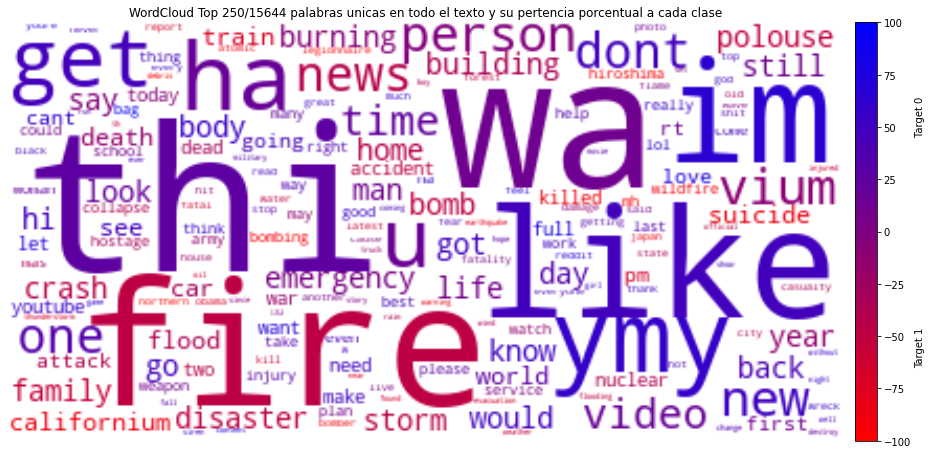

In [9]:
# type(pd_str_value_counts.full_text) # pandas.core.series.Series

n_words = 250

dict_freq = pd_str_value_counts.full_text.to_dict()

fig, axes = plt.subplots(nrows=1, ncols=1)
wc = WordCloud(background_color='white', normalize_plurals=True, max_words=n_words,prefer_horizontal=1 ).generate_from_frequencies(dict_freq)
wc.recolor(color_func = wd_color_belonging)

axes.imshow(wc,interpolation="bilinear")
fig.set_size_inches(15, 10)
axes.axis('off')
axes.set_title( 'WordCloud Top %d/%d palabras unicas en todo el texto y su pertencia porcentual a cada clase' %(n_words,len(dict_freq) )  )

add_red_green_target_colorbar(fig,axes)

En el wordcloud anterior podemos ver las 250 palabras más frecuentes en todo el texto, las mismas alteran de color entre rojo(Target 1) y azul(Target 0) cuanto más frecuente sea en una clase que en la otra.

# Word Cloud Top Uniq by Target

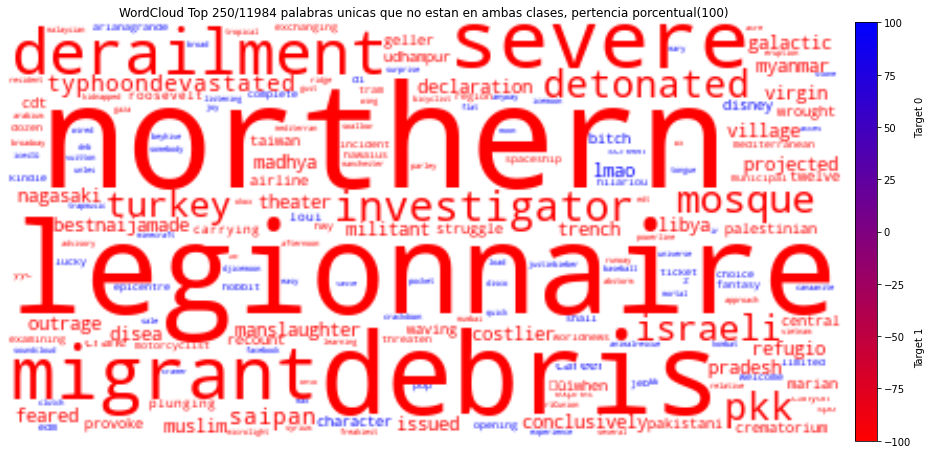

In [10]:
# n_words = 100
dict_freq_uniq_words = pd_str_value_counts[ (pd_str_value_counts.t0 == 0)  |  (pd_str_value_counts.t1 == 0 ) ].full_text.to_dict()


fig, axes = plt.subplots(nrows=1, ncols=1)
wc = WordCloud(background_color='white', normalize_plurals=True, max_words=n_words,prefer_horizontal=1 ).generate_from_frequencies(dict_freq_uniq_words)
wc.recolor(color_func = wd_color_belonging)

axes.imshow(wc,interpolation="bilinear")
fig.set_size_inches(15, 10)
axes.axis('off')

axes.set_title('WordCloud Top %d/%d palabras unicas que no estan en ambas clases, pertencia porcentual(100) ' %(n_words,len(dict_freq_uniq_words) ) )

add_red_green_target_colorbar(fig,axes)


En el wordcloud anterior podemos ver las 250 palabras más frecuentes en todo el texto que solo se encuentran de forma exclusiva solo en una de las clases. En rojo las que son Target 1 y azul Target 0.




Text(0.5, 1.0, 'WordCloud Top 250/4535 palabras unicas en Target 1')

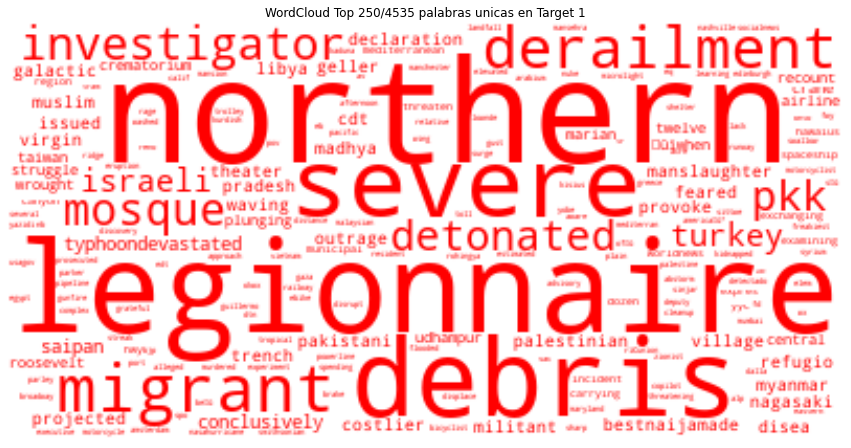

In [11]:
# T0 = 0 implica solo me quedo con target 1
dict_freq_uniq_words = pd_str_value_counts[ (pd_str_value_counts.t0 == 0) ].full_text.to_dict()

fig, axes = plt.subplots(nrows=1, ncols=1)
wc = WordCloud(background_color='white', normalize_plurals=True, max_words=n_words,prefer_horizontal=1 ).generate_from_frequencies(dict_freq_uniq_words)
wc.recolor(color_func = wd_color_belonging)


axes.imshow(wc,interpolation="bilinear")
fig.set_size_inches(15, 10)
axes.axis('off')
axes.set_title('WordCloud Top %d/%d palabras unicas en Target 1' %(n_words,len(dict_freq_uniq_words) )) 

En el wordcloud anterior podemos ver las 250 palabras más frecuentes que solo se encuentran presentes en tweets de clase 1.

Text(0.5, 1.0, 'WordCloud Top 250/7449 palabras unicas en Target 0')

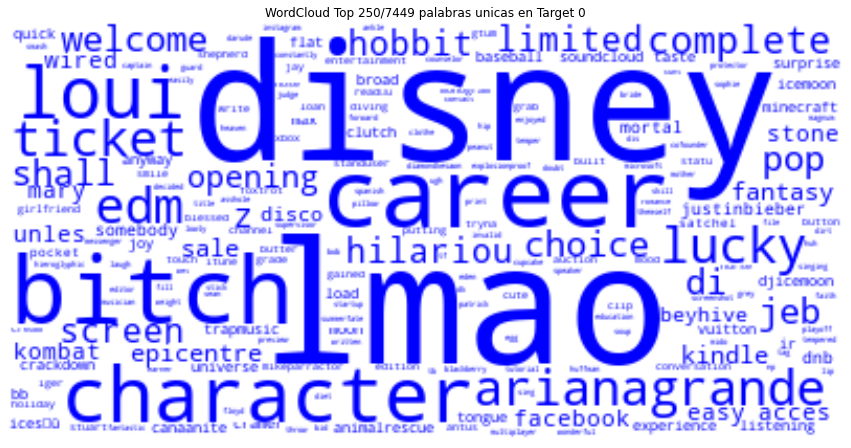

In [12]:
# T1 = 0 implica solo me quedo con target 0
dict_freq_uniq_words = pd_str_value_counts[ (pd_str_value_counts.t1 == 0) ].full_text.to_dict()

fig, axes = plt.subplots(nrows=1, ncols=1)
wc = WordCloud(background_color='white', normalize_plurals=True, max_words=n_words,prefer_horizontal=1 ).generate_from_frequencies(dict_freq_uniq_words)
wc.recolor(color_func = wd_color_belonging)

axes.imshow(wc,interpolation="bilinear")
fig.set_size_inches(15, 10)
axes.axis('off')
axes.set_title('WordCloud Top %d/%d palabras unicas en Target 0' %(n_words,len(dict_freq_uniq_words) ) )

En el wordcloud anterior podemos ver las 250 palabras más frecuentes que solo se encuentran presentes en tweets de clase 0.

# PLOTBAR

1.   Frecuencia de palabras con visualización por clase
2.   Frecuencia de palabras más usadas que se encuentran exclusivamente en clase 0
2.   Frecuencia de palabras más usadas que se encuetran exclusivamente en clase 1

Text(0, 0.5, 'Ocourrencias [N]')

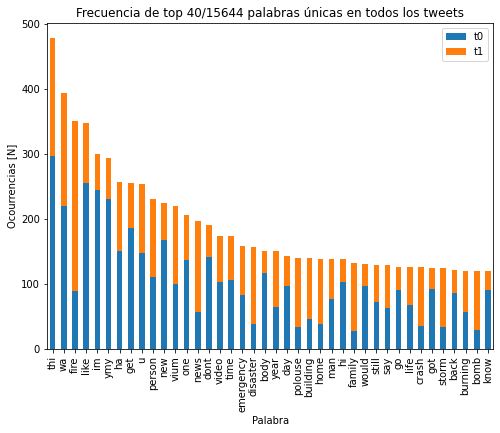

In [13]:
# Hago un grafico comparativo de cantidad de ocurrenncias de cada palabra segun la clase a la que corresponde
n_words = 40

# Grafico Vertical
fig, axes = plt.subplots(nrows=1, ncols=1)
ax = pd_str_value_counts.sort_values(by=['full_text'] , ascending=False ,inplace=False)\
.head(n_words)[['t0' , 't1']]\
.plot.bar(ax=axes , stacked=True  , rot=90, figsize=(15,10), title="Frecuencia de top %d/%d palabras únicas en todos los tweets" %(n_words, len(pd_str_value_counts) )  )

fig.set_size_inches(8, 6)


ax.set_xlabel("Palabra")
ax.set_ylabel("Ocourrencias [N]")


En el plotbar anterior podemos ver las 40 palabras más frecuentas en todos los tweets.  Además se puede diferenciar por color la cantidad de ocurrencias según la clase.

# PLOTBAR_UNIQ

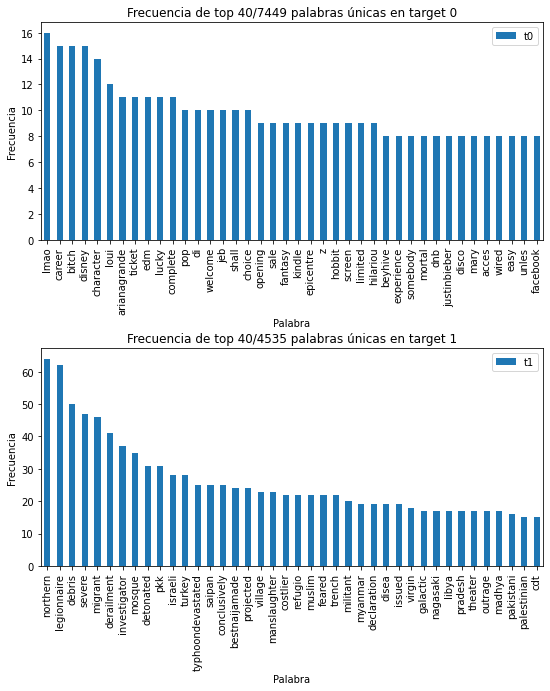

In [14]:
# Top uniq word target 0
fig, axes = plt.subplots(nrows=2, ncols=1)
ax = pd_str_value_counts[ pd_str_value_counts.t1 == 0 ].sort_values(by=['t0'] , ascending=False ,inplace=False)\
.head(n_words)[['t0']]\
.plot.bar(ax=axes[0] , stacked=True  , rot=90, figsize=(10,8), title="Frecuencia de top %d/%d palabras únicas en target 0" %(n_words,sum(pd_str_value_counts.t1 == 0)))

axes[0].set_xlabel("Palabra")
axes[0].set_ylabel("Frecuencia")

# Top uniq word target 1 
# fig, axes = plt.subplots(nrows=1, ncols=1)
ax = pd_str_value_counts[ pd_str_value_counts.t0 == 0 ].sort_values(by=['t1'] , ascending=False ,inplace=False)\
.head(n_words)[['t1']]\
.plot.bar(ax=axes[1] , stacked=True  , rot=90, figsize=(10,8), title="Frecuencia de top %d/%d palabras únicas en target 1" %(n_words,sum(pd_str_value_counts.t0 == 0)))

axes[1].set_xlabel("Palabra")
axes[1].set_ylabel("Frecuencia")

plt.subplots_adjust(hspace=0.5)
fig.set_size_inches(9, 10)




En los dos plotbar anteriores podemos ver las 40 palabras más frecuentas que se encuentran de forma exclusiva en una clase o en la otra. Al comparar los dos gráficos se puede apreciar que los tweets de catástrofes(Target 1) tienen palabras que se repiten con mucho más frecuencia.

Se puede apreciar que para clase 1 *northern* y *legionaries* son las que tienen mayor frecuencia y se repiten alrededor de 60 veces.

Se puede apreciar que para clase 0 *lmao* y *career* son las de mayor frecuencias con alrededor de 15 ocurrencias.

La conclusión más importnte que se puede sacar de esto es que a pesar de que hay más tweets de target 0 los mismos tienen mucha mayor variabilidad de palabras

# Contenido de palabars unicas por tweet

Buscamos en los tweets cuantas palabras unicas asociadas a cada target posee cada uno

**pd_clean_text** DataFrame original al cual solo se le filtraron palabaras de su texto y normalizo

**pd_str_value_counts** DataFrame que cuenta la cantidad de palabras de cada tipo


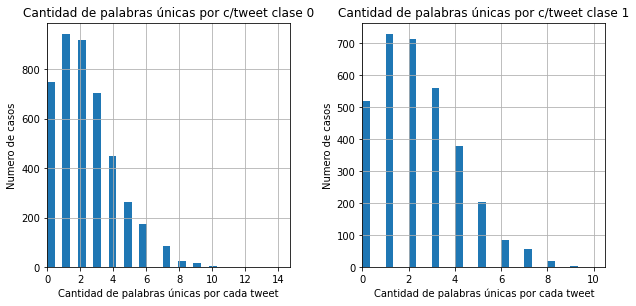

In [15]:
list_t0_uniq_words = pd_str_value_counts[ (pd_str_value_counts.t1 == 0) ].index
list_t1_uniq_words = pd_str_value_counts[ (pd_str_value_counts.t0 == 0) ].index


fig, axes = plt.subplots(nrows=1, ncols=2)

pd_clean_text[ pd_clean_text.target == 0 ].text\
.apply( lambda x: len( [a for a in x.split() if a in list_t0_uniq_words]  ) )\
.plot.hist( ax = axes[0] , bins= 30, alpha=1 , grid=True, title = 'Cantidad de palabras únicas por c/tweet clase 0')
axes[0].set_xlim(left=0)
axes[0].set_xlabel('Cantidad de palabras únicas por cada tweet' )
axes[0].set_ylabel('Numero de casos' )

pd_clean_text[ pd_clean_text.target == 1 ].text\
.apply( lambda x: len( [a for a in x.split() if a in list_t1_uniq_words]  ) )\
.plot.hist( ax = axes[1] , bins= 30, alpha=1 , grid=True, title = 'Cantidad de palabras únicas por c/tweet clase 1')
axes[1].set_xlim(left=0)
axes[1].set_xlabel('Cantidad de palabras únicas por cada tweet' )
axes[1].set_ylabel('Numero de casos' )

plt.subplots_adjust(hspace=0.3)
plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(10,4.5)

Se puede observar que con target==0 hay casi 800 tweets que no tiene palabras únicas de la clase, casi mil que tienen una, mil con dos, setescientos con tres,etc.

Se puede observar que con target==1 hay poco maś de 500 tweets que no tienen palabrás unicas de la clase 1, alrededor de setescientos con una palabra única, setescientas con dos palabras de la clase,etc.

Teniendo en cuenta que hay un total de 7500 tweets y 1300 que no tienen palabras únicas, si solo usaramos las palabras únicas como criterio de clasificación lo haríamos de manera correcta para el 83% de los casos, y para el resto no tendríamos una categoría asignada. 

La ventaja de que este método no asigne categorías erróneas es que fácilemte podrían pasarse a alguna clase de control secundario para intentar diferenciarlos de otra forma, ya que si se hubiesen clasificado erroneamente no serían detectables.



# Distribución porcentual de palabras por tweet

Buscamos en los tweets cuantas palabras unicas asociadas a cada target tiene

Basados en el análisis de palabras únicas a cada clase realizado anteriormente analizaremos, buscaremos si existen palabras que mayoritariamente estén en una clase en lugar de la otra, a este método lo llamaremos clasificación por palabras **semi únicas**

**pd_clean_text** DataFrame original al cual solo se le filtraron palabaras de su texto y normalizo

**pd_str_value_counts** DataFrame que cuenta la cantidad de palabras de cada tipo


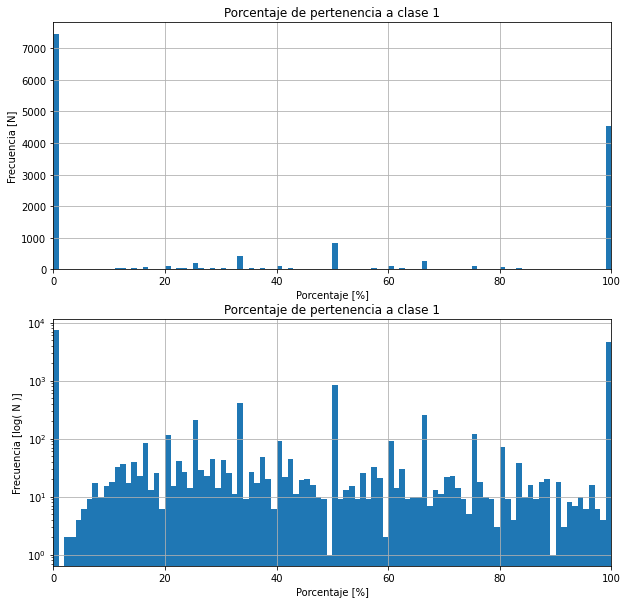

In [16]:
# fig, axes = plt.subplots(nrows=1, ncols=1)
# pd_str_value_counts[['t0_belonging_perc' , 't1_belonging_perc']]\
# .plot.hist(ax=axes,bins=100, alpha=0.4 , title="Porcentaje de pertenencia a clase X")

fig, axes = plt.subplots(nrows=2, ncols=1)

pd_str_value_counts[['t1_belonging_perc' ]]\
.plot.hist(ax=axes[0],bins=100, alpha=1 , logy=False, legend=False, grid=True,  title="Porcentaje de pertenencia a clase 1")
axes[0].set_xlabel('Porcentaje [%]')
axes[0].set_ylabel('Frecuencia [N]')
axes[0].set_xlim(left=0, right=100)


pd_str_value_counts[['t1_belonging_perc' ]]\
.plot.hist(ax=axes[1],bins=100, alpha=1 , logy=True, legend=False, grid=True,  title="Porcentaje de pertenencia a clase 1")
axes[1].set_xlabel('Porcentaje [%]')
axes[1].set_ylabel('Frecuencia [log( N )]')
axes[1].set_xlim(left=0, right=100)


fig.set_size_inches(10,10)



En el gráfico anterior se puede observar para todas las palabras que están en los tweets el porcentaje de veces que aparecen en tweets de clase 1. 

Solo realizamos el gráfico para una clase ya que para la otra el gráfico es igual pero con los porcentajes invertidos. 

Se muestra el mismo gráfico con eje *y* en escala lineal y logarítmica, ya que si solo lo vemos con escala lineal la mayoria de las palabras con un porcentaje de ocurrencia entre 0 y 100 quedarían enmascardos por tener una aparición de un orden de magnitud menor en veces.


Al hacer la lectura vemos que hay alrededor de 4500 palabras que el %100  de las veces que aparecen se encuentra en tweets de clase 1, 7500 que el 0% de las veces que aparecen se encuentran en tweets de clase 1 y mil que aparecen de forma casi equiprobable en ambos. Además se encuentran algunos picos adicionales que indican palabras que aprecen más en una clase u otra, pero no lo suficiente para usarlas como método de clasificación, por lo cual podríamos descartar un método de clasificación por palabras semi únicas.





In [17]:
# pd_str_value_counts_reduced = pd_str_value_counts[   ]
pd_str_value_counts_reduced = pd_str_value_counts[ pd_str_value_counts.t1_belonging_perc != 100 ]
pd_str_value_counts_reduced = pd_str_value_counts_reduced[ pd_str_value_counts_reduced.t1_belonging_perc != 0 ]

# pd_str_value_counts_reduced = pd_str_value_counts_reduced[ (pd_str_value_counts_reduced.t1_belonging_perc < 20) | (pd_str_value_counts_reduced.t1_belonging_perc > 80) ]

pd_str_value_counts_reduced



,full_text,t1,t0,t0_belonging_perc,t1_belonging_perc
thi,478,181.0,297.0,62.133891,37.866109
wa,393,174.0,219.0,55.725191,44.274809
fire,350,262.0,88.0,25.142857,74.857143
like,347,92.0,255.0,73.487032,26.512968
im,300,56.0,244.0,81.333333,18.666667
...,...,...,...,...,...
peak,2,1.0,1.0,50.000000,50.000000
european,2,1.0,1.0,50.000000,50.000000
responding,2,1.0,1.0,50.000000,50.000000
mû,2,1.0,1.0,50.000000,50.000000


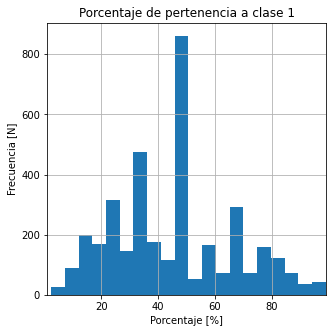

In [18]:
n_bins = 20


fig, axes = plt.subplots(nrows=1, ncols=1)
pd_str_value_counts_reduced[['t1_belonging_perc' ]]\
.plot.hist(ax=axes,bins=n_bins, alpha=1 , logy=False, legend=False, grid=True,  title="Porcentaje de pertenencia a clase 1")
axes.set_xlabel('Porcentaje [%]')
axes.set_ylabel('Frecuencia [N]')
axes.set_xlim(left=1, right=99)

fig.set_size_inches(5,5)

En el gráfico anterior podemos observar como se distribuye el porcentaje de pertenencia de clase sin contar los extremos que enmascaran el resto de las muestras